In [25]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

from pyslfp import FingerPrint, plot_SHGrid, ResponseFields
import oldsolver.RFmod as RF
import oldsolver.SLmod as SL
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as crs 
import cartopy.feature as cfeature
import cmocean
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Plotting 
def plot_from_shgrid(fun, ax, vmin=None, vmax=None, cmap='cmo.balance_r'):
    ## Function that organises SHGrid objects and plots them correctly
    ## Might be extended to include plot_kwargs and cbar_kwargs

    if vmin is None and vmax is None:
        maxval = np.max(np.abs(fun.data))
        vmin = -maxval
        vmax = maxval

    field = ax.pcolormesh(fun.lons()-180,fun.lats(),fun.data, cmap=cmap, vmin=vmin, vmax=vmax)
    
    axins = inset_axes(ax, width="100%",height="5%",loc='lower left',bbox_to_anchor=(0.00, -0.15, 1, 1),bbox_transform=ax.transAxes,borderpad=0)
    cbar = plt.colorbar(field,cax=axins,orientation='horizontal')
    #cbar.set_label(r'[Mass / Unit area]',labelpad=8)

# SH coeffs
def convert_glq_to_vector_of_sh_coeffs(glq_grid, L):
    ## Converts a GLQ grid to a vector of SH coefficients
    ## For reference: Clm = phi_coeffs[0,l,m>=0] and Slm = phi_coeffs[1,l,m>=1]

    coeffs = glq_grid.expand(normalization = 'ortho').to_array()

    coeffs_vec = np.zeros(((L+1)**2))       
    for l in range(L+1):
        coeffs_vec[(l)**2:(l+1)**2] = np.concatenate((coeffs[1,l,1:l+1][::-1],coeffs[0,l,0:l+1]))
    
    return coeffs_vec

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
# Aim: to compare fingerprint calculations between the old and new codes

# Preliminaries for the old code
L = 128
Q = RF.sobolev_covariance(L, s=2, mu=0.2)
sl0,ice0 = SL.get_sl_ice_data(L)
C = SL.ocean_function(sl0,ice0)
rhow = SL.rhow
b = SL.b
g = SL.g

# Preliminaries for the new code
fingerprint = FingerPrint(L, grid='GLQ')
fingerprint.set_background_state_from_ice_ng(version = 6)


[[<cartopy.mpl.feature_artist.FeatureArtist at 0x7f17a4540bd0>,

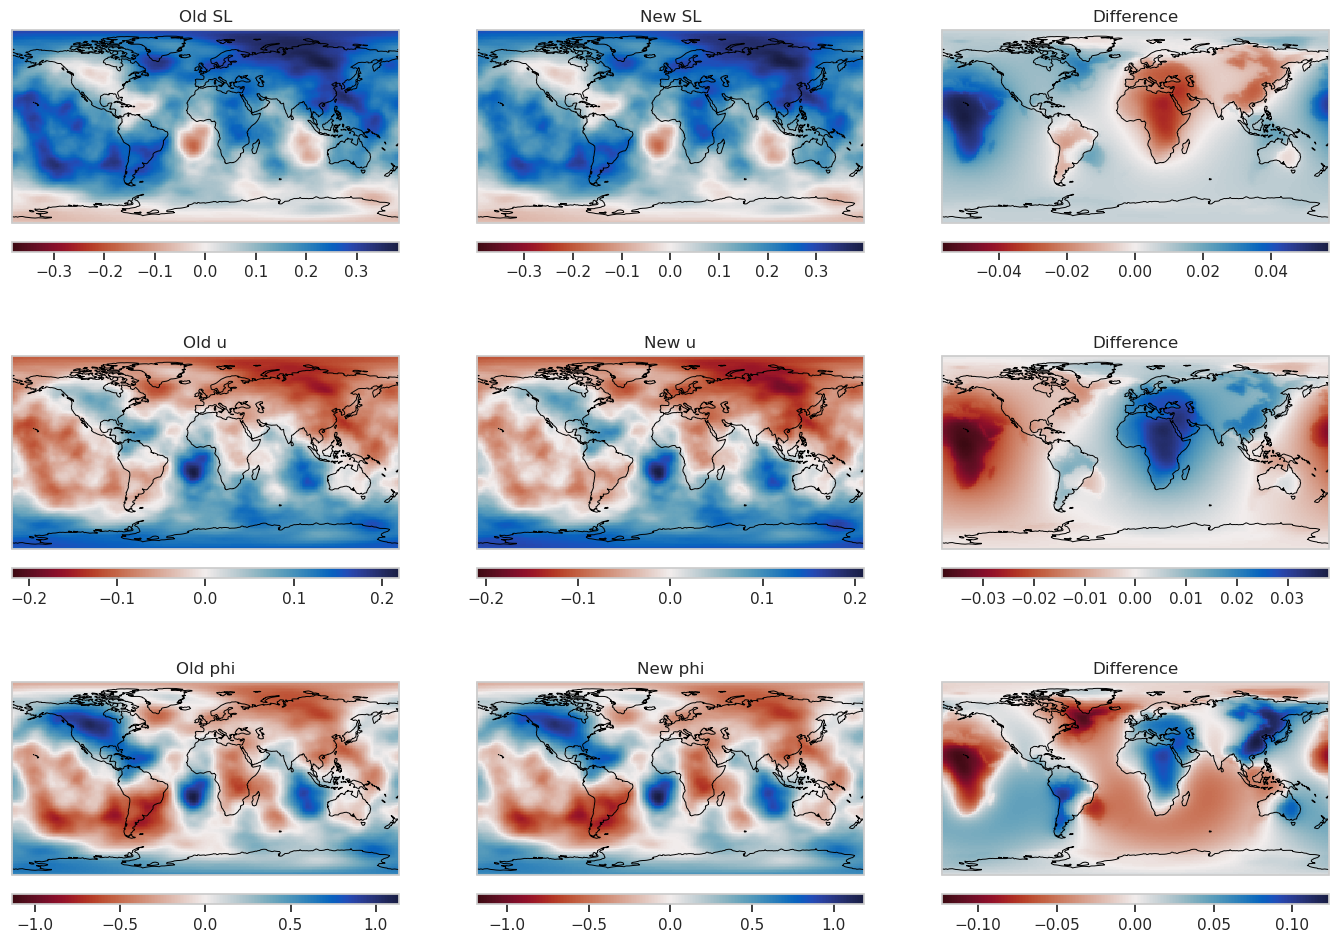

In [52]:
# Create a random load, and calculate the response fields using both codes
zeta = -rhow * RF.random_field(Q)

# Old code
sl, u, phi, om, _ = SL.fingerprint(C, zeta, verbose=False, rotation=False)
old_response = ResponseFields(u, phi, om, sl)

# New code
new_response = fingerprint.solver(zeta, rotational_feedbacks=False)

# Compare the response fields
fig, ax = plt.subplots(3, 3, figsize=(17,12), subplot_kw=dict(projection=crs.PlateCarree()))

# sl
plot_from_shgrid(old_response.sl, ax[0,0])
plot_from_shgrid(new_response.sl, ax[0,1])
plot_from_shgrid(old_response.sl - new_response.sl, ax[0,2])
[a.set_title(t) for a,t in zip(ax[0,:], ['Old SL', 'New SL', 'Difference'])]

# u
plot_from_shgrid(old_response.u, ax[1,0])
plot_from_shgrid(new_response.u, ax[1,1])
plot_from_shgrid(old_response.u - new_response.u, ax[1,2])
[a.set_title(t) for a,t in zip(ax[1,:], ['Old u', 'New u', 'Difference'])]

# phi
plot_from_shgrid(old_response.phi, ax[2,0])
plot_from_shgrid(new_response.phi, ax[2,1])
plot_from_shgrid(old_response.phi - new_response.phi, ax[2,2])
[a.set_title(t) for a,t in zip(ax[2,:], ['Old phi', 'New phi', 'Difference'])]

[[a.add_feature(cfeature.COASTLINE, zorder=1, linewidth=0.7) for a in ax[i,:]] for i in range(3)]

(0.0, 20.0)

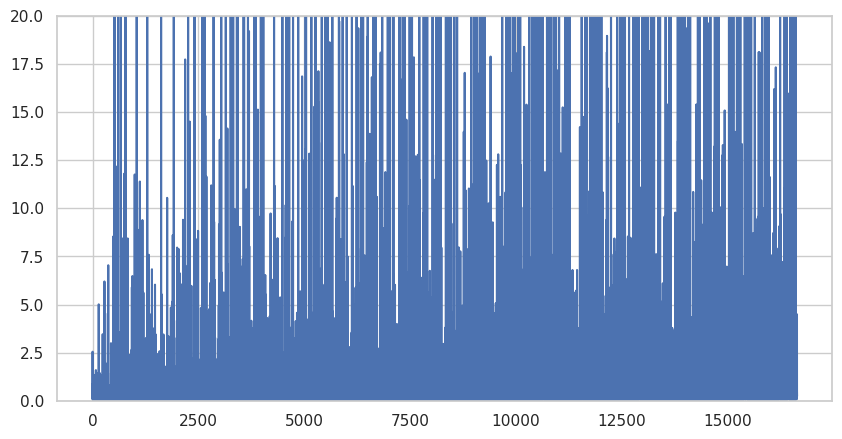

In [53]:
# Compare spherical harmonic coefficients

# Do phi first becuase it looks like the discrepancy is in degree 2
old_vec = convert_glq_to_vector_of_sh_coeffs(old_response.phi, L)
new_vec = convert_glq_to_vector_of_sh_coeffs(new_response.phi, L)

normalised_difference = np.abs(old_vec - new_vec) / (np.abs(old_vec + new_vec) /2)

#plot with y axis running from 0 to 1
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(normalised_difference)
ax.set_ylim(0,20)

(<Figure size 640x352 with 1 Axes>,
 <Axes: xlabel='GLQ longitude index', ylabel='GLQ latitude index'>)

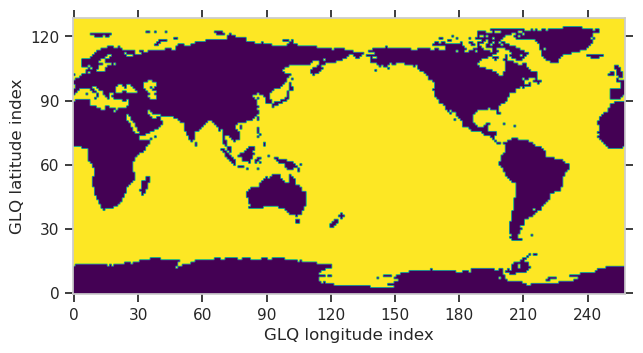

In [54]:
fingerprint.ocean_function.plot()

(<Figure size 640x352 with 1 Axes>,
 <Axes: xlabel='GLQ longitude index', ylabel='GLQ latitude index'>)

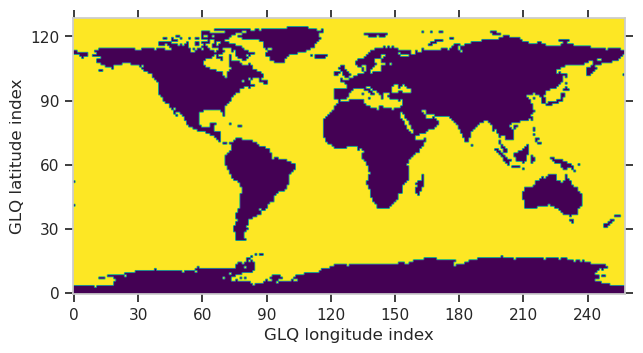

In [55]:
SL.ocean_function(sl0,ice0).plot()

[[<cartopy.mpl.feature_artist.FeatureArtist at 0x7f173c7d8150>,

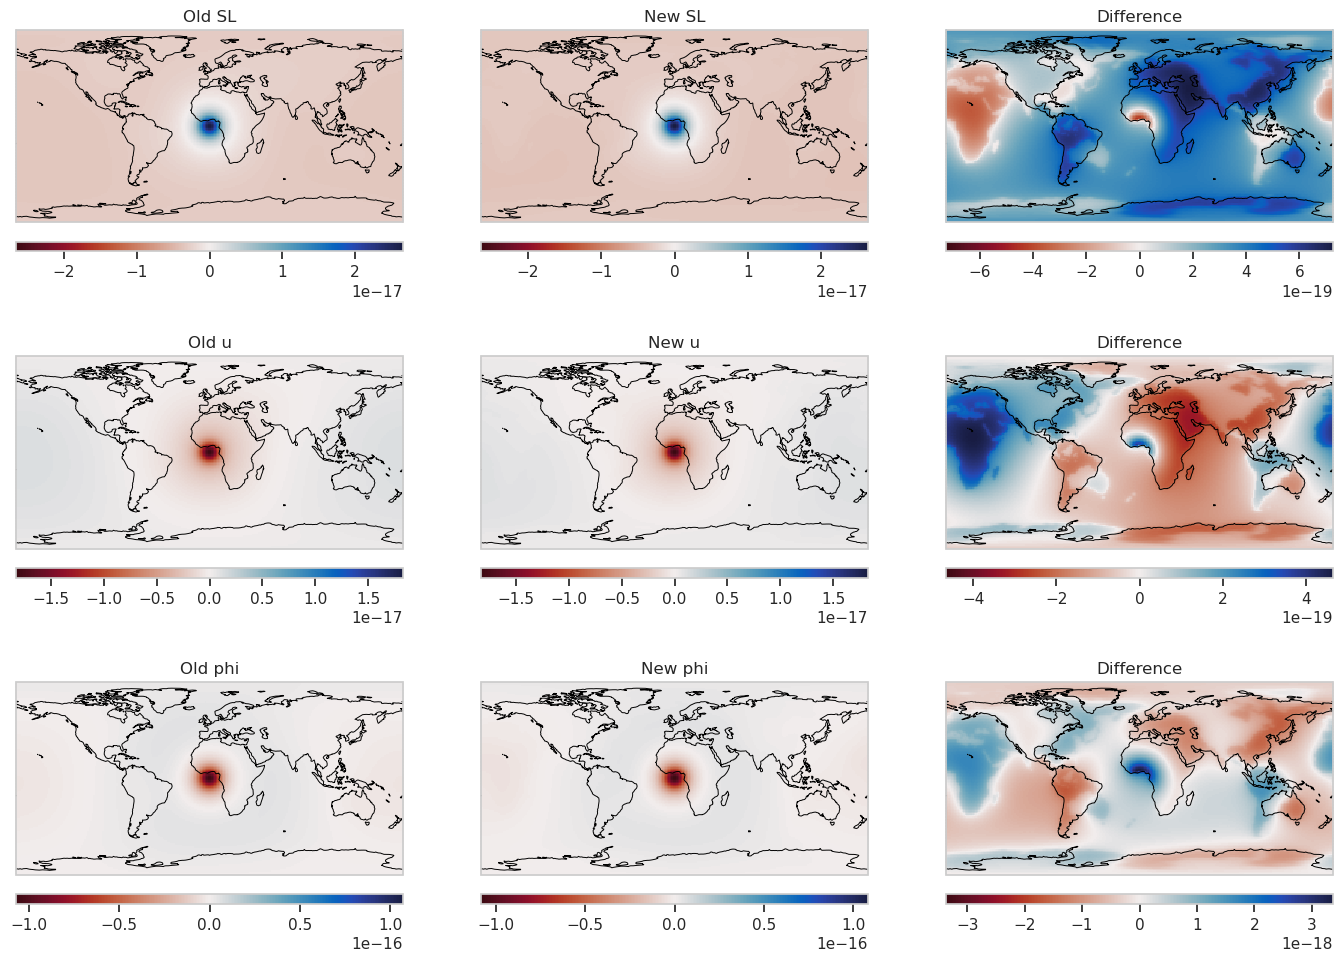

In [61]:
# They do not match because the ocean function in the new code is translated 180 in longitude

# Test using a point load, generated from the old and new codes respectively
delta_zeta_old = SL.point_load(L, np.array([0]), np.array([0]), angle = 10)
delta_zeta_new = fingerprint.point_load(0, 0, delta = 10)

# Redo the plots with these loads
# Old code
sl, u, phi, om, _ = SL.fingerprint(C, delta_zeta_old, verbose=False, rotation=False)
delta_response_old = ResponseFields(u, phi, om, sl)

# New code
delta_response_new = fingerprint.solver(delta_zeta_new, rotational_feedbacks=False)

# Compare the response fields
fig, ax = plt.subplots(3, 3, figsize=(17,12), subplot_kw=dict(projection=crs.PlateCarree()))

# sl
plot_from_shgrid(delta_response_old.sl, ax[0,0])
plot_from_shgrid(delta_response_new.sl, ax[0,1])
plot_from_shgrid(delta_response_old.sl - delta_response_new.sl, ax[0,2])
[a.set_title(t) for a,t in zip(ax[0,:], ['Old SL', 'New SL', 'Difference'])]

# u
plot_from_shgrid(delta_response_old.u, ax[1,0])
plot_from_shgrid(delta_response_new.u, ax[1,1])
plot_from_shgrid(delta_response_old.u - delta_response_new.u, ax[1,2])
[a.set_title(t) for a,t in zip(ax[1,:], ['Old u', 'New u', 'Difference'])]

# phi
plot_from_shgrid(delta_response_old.phi, ax[2,0])
plot_from_shgrid(delta_response_new.phi, ax[2,1])
plot_from_shgrid(delta_response_old.phi - delta_response_new.phi, ax[2,2])
[a.set_title(t) for a,t in zip(ax[2,:], ['Old phi', 'New phi', 'Difference'])]

[[a.add_feature(cfeature.COASTLINE, zorder=1, linewidth=0.7) for a in ax[i,:]] for i in range(3)]